# start

- http://localhost:8081/notebooks/git/recsys20/working/0324_6_3_lgb_feat_engr-1e7.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/mdl0404_1__xgb_mean_encode.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/eda_0404_1.ipynb#v.s.-target
- https://www.kaggle.com/discdiver/category-encoders-examples
- https://www.kaggle.com/snakayama/lightgbm-using-optuna-optuna-lightgbm

In [1]:
TGT='Like'
PRFX='Like0411_1'

trntmstmp=1584412344
tsttmstmp=1586133347

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_tst_min,tm_tst_max=(1581552000, 1582156799)

SEED=101

valsz = int(5e5)#int(1e5)
trnsz = int(5e5)#int(5e5)

train_total=148075238
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')


import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, tsttmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_tst_min,tm_tst_max)])

train_total 148,075,238, test_total 14,000,000
['2020-03-17 02:32:24', '2020-04-06 00:35:47']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


# setup

In [2]:
from tqdm import tqdm
import time
from pathlib import Path
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
# import xgboost as xgb
# import lightgbm as lgb
import category_encoders as ce
import gc

import optuna
# optuna.logging.CRITICAL, optuna.logging.FATAL
# optuna.logging.ERROR
# optuna.logging.WARNING, optuna.logging.WARN
# optuna.logging.INFO
# optuna.logging.DEBUG
# optuna.logging.set_verbosity(optuna.logging.ERROR)
import optuna.integration.lightgbm as lgb
optuna.logging.disable_default_handler()


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 
def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    (((1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)) +
     (data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop))))
    return calibrated_data


cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_fllwer_cnt','u2_fllwng_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
TCOL=tgt2col[TGT]
print('TCOL', TCOL)
print(tgt2col)

TCOL like
{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [3]:
def prp_tgt(df):
    df[cols_tgt]=df[cols_tgt_tmstmp].notna()
    df.drop(columns=cols_tgt_tmstmp, inplace=True)
    display(df[cols_tgt].mean())

In [4]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)
print(dfval.shape)
prp_tgt(dfval)

(500000, 24)


retwt          0.112638
reply          0.027980
like           0.439010
retwt_cmmnt    0.007676
dtype: float64

CPU times: user 3.58 s, sys: 440 ms, total: 4.02 s
Wall time: 4.02 s


## maybe oversample

In [5]:
# df = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=5)
# dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=2)
# dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,skiprows=2,nrows=3)
# display(df.twtid)
# display(dfval.twtid)
# display(dftrn.twtid)

# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# 2    519078C7834E9642508F72A6C2D0F3B7
# 3    52AAE9E33EFAC8C478C57B31A9E31ED1
# 4    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object
# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# Name: twtid, dtype: object
# 0    519078C7834E9642508F72A6C2D0F3B7
# 1    52AAE9E33EFAC8C478C57B31A9E31ED1
# 2    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object

In [6]:
%%time
if TGT in ('Retweet','Like'): trnpop=trnsz
if TGT=='Reply': trnpop=trnsz*3.7
if TGT=='RTwCmnt': trnpop=trnsz*11.5
assert trnpop<train_total

dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz, nrows=trnpop)
print(dftrn.shape)
prp_tgt(dftrn)

(500000, 24)


retwt          0.113632
reply          0.027396
like           0.438598
retwt_cmmnt    0.007824
dtype: float64

CPU times: user 4.43 s, sys: 336 ms, total: 4.76 s
Wall time: 4.76 s


In [7]:
train_pop=len(dftrn)
sampled_train_pop=trnsz
idx_pos = np.where(dftrn[TCOL])[0]
target_pop=sampled_target_pop=len(idx_pos)
if TGT in ('Reply','RTwCmnt'):
    idx_neg0 = np.where(~dftrn[TCOL])[0]
    idx_neg = np.random.choice(idx_neg0, trnsz-len(idx_pos), replace=False)
    idx = np.concatenate([idx_pos,idx_neg])
    dftrn = dftrn.iloc[idx].copy()
print(dftrn.shape, dftrn[TCOL].mean())
print(train_pop, target_pop, sampled_train_pop, sampled_target_pop)

display(dftrn.head())
display(dftrn.columns)

(500000, 24) 0.438598
500000 219299 500000 219299


,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,u1_fllwer_cnt,u1_fllwing_cnt,u1_vrfed,u1_create_tm,u2id,u2_fllwer_cnt,u2_fllwng_cnt,u2_vrfed,u2_create_tm,u1_fllw_u2,retwt,reply,like,retwt_cmmnt
0,101\t56898\t137\t14248\t10567\t77966\t11166\t1...,NaN,A964AF200DAFFEBCB632CE2196DFBE6F,NaN,NaN,NaN,Retweet,022EC308651FACB02794A8147AEE1B78,1581227402,E43C242721C2336F88D163ADFDB2A364,27901,306,False,1351736247,06E9B34C49824F5C612B01F3DF66C4B8,48,977,False,1493475569,False,True,False,False,False
1,101\t29922\t10230\t112\t11368\t112\t12469\t169...,NaN,CA95806CCD16ADD6164D8B632345A5B6,NaN,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581415813,520F4141FB74447AA2D5100C12656DF2,190829,2227,True,1246308293,06E9B485CA5F2757CB554B0244FE2FA4,2024,1227,False,1234745553,False,False,False,True,False
2,101\t16358\t10107\t117\t146\t100\t181\t32342\t...,NaN,EAB281F4E0B985324DB134D922D7753C,NaN,NaN,NaN,Quote,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581524517,EC1254C86CED1D8F2B556786329FD939,225223,1365,True,1238211373,06E9B485CA5F2757CB554B0244FE2FA4,2024,1227,False,1234745553,False,True,False,True,False
3,101\t49004\t24951\t11517\t21793\t49004\t46900\...,E35EBE28C67E02E3EAABD4D383303A10\tBF43374FADDC...,55F436653590B79DC49DCA2FC5E6BA6E,Photo,NaN,NaN,TopLevel,06D61DCBBE938971E1EA0C38BD9B5446,1581098413,09567D1DEB473ABA2CD04D06F1F6D22D,3110429,39,True,1243169868,06E9B6ABEB6C57CA5A394DADF375D940,557,466,False,1509320658,False,False,False,True,False
4,101\t320\t108660\t18492\t105861\t26349\t10174\...,NaN,2F374BA8A03CFA7B51594FBBD45E4BA6,Photo,E07397470C5AD4AC2420A832A49E045B,476213C6321CD12B64C1FB76A6CE02CA,TopLevel,4DC22C3F31C5C43721E6B5815A595ED6,1581158393,DF856F242E9519638FD447D0CCFA06DF,4245504,54,True,1248789982,06E9B7217C92B280231E835F1B686176,8,74,False,1346060212,False,False,False,False,False


Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u2_create_tm', 'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt'],
      dtype='object')

## prep and features

In [8]:
def prp_df(df, tm_max):
    '''
    tm_max = tm_trn_max for train tm_tst_max for test
    '''
    lendf = len(df)
    print(dtnow(), 'start')
    set_u1 = set(df.u1id)
    set_u2 = set(df.u2id)
    df['u1inu2']=df.u1id.isin(set_u2)
    df['u2inu1']=df.u2id.isin(set_u1)

    #counts
    df['len_toks'] = df.toks.apply(lambda x: len(x.split('\t')))
    df.drop(columns=['toks'], inplace=True)    
    for m in ['Photo', 'Video', 'GIF']:
        df[f'n_media_{m}'] = df['media'].fillna('').apply(lambda x: x.split('\t').count(m))
    tgnms = ['hshtgs','media', 'links', 'domns',]
    for tgnm in tgnms:
        df[f'has_{tgnm}']=df[tgnm].notna()
        df[f'lst_{tgnm}'] = df[tgnm].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tgnm}'] = df[f'lst_{tgnm}'].apply(len)  
    df.drop(columns=['has_links','n_links'], inplace=True) #duplicates has_domns,n_domns 
    
    #time
    dt = pd.to_datetime(df.tm, unit='s')
    df['dayofweek'] = dt.dt.dayofweek
    df['hour'] = dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    df['twt_age']   = tm_max-df.tm
    df['u1_age']    = tm_max-df.u1_create_tm
    df['u2_age']    = tm_max-df.u2_create_tm
    df.drop(columns=['tm', 'u1_create_tm', 'u2_create_tm'], inplace=True)

    #time derived
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    #interaction
    df['u1u2']=df.u1id+'_'+df.u2id
    df['langhour']=df.lang+'_'+df.hour.astype(str)
    

    #freq of feature values
    print(dtnow(), 'freq of columns using CountEncoder')
    encoder = ce.CountEncoder()
    encoded = encoder.fit_transform(
    df[['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
       'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
       'dayofweek', 'hour', 'u1u2', 'langhour']].astype(object))
    encoded = encoded.astype(int)/lendf
    encoded.columns = [f'frq_{col}' for col in encoded.columns]
    df = pd.concat([df,encoded],1)
    
    #freq of tgnm values
    print(dtnow(), 'freq of tags')
    for tgnm in tgnms:
        vs = [j for i in df[f'lst_{tgnm}'] for j in i]
        cnt = Counter(vs)
        frq = {k:v/lendf for k,v in cnt.items()}
        df[f'sumfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: sum([frq.get(o,0) for o in x]))
        df[f'maxfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: max([frq.get(o,0) for o in x]) if len(x) else 0)
    df.drop(columns=tgnms+[f'lst_{tgnm}' for tgnm in tgnms],inplace=True)

    print(dtnow(), 'done')
    return df

In [9]:
%%time
dftrn=prp_df(dftrn, tm_max=tm_trn_max)

2020-04-11 22:56:39 start
2020-04-11 22:56:47 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-11 22:56:59 freq of tags
2020-04-11 22:57:03 done
CPU times: user 21.3 s, sys: 3.24 s, total: 24.5 s
Wall time: 24.3 s


In [10]:
%%time
dfval=prp_df(dfval, tm_max=tm_trn_max)

2020-04-11 22:57:03 start
2020-04-11 22:57:11 freq of columns using CountEncoder
2020-04-11 22:57:23 freq of tags
2020-04-11 22:57:27 done
CPU times: user 20.8 s, sys: 3.15 s, total: 23.9 s
Wall time: 23.8 s


## tr vl split and target encoding

In [11]:
msk_vl=np.random.rand(len(dftrn))<0.15
idxvl=np.where( msk_vl)[0]
idxtr=np.where(~msk_vl)[0]

dftr = dftrn.iloc[idxtr].copy()
dfvl = dftrn.iloc[idxvl].copy()
del dftrn

gc.collect()

30

In [12]:
dftr.columns

Index(['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt',
       'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt', 'u1inu2',
       'u2inu1', 'len_toks', 'n_media_Photo', 'n_media_Video', 'n_media_GIF',
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media', 'has_domns',
       'n_domns', 'dayofweek', 'hour', 'tmdlta_u2u1', 'tmdlta_twtu1',
       'tmdlta_twtu2', 'twt_age', 'u1_age', 'u2_age', 'u1_fllwer_cnt_by_age',
       'u1_fllwng_cnt_by_age', 'u1u2', 'langhour', 'frq_twtid', 'frq_twttyp',
       'frq_lang', 'frq_u1id', 'frq_u1_fllwing_cnt', 'frq_u1_vrfed',
       'frq_u2id', 'frq_u2_fllwer_cnt', 'frq_u2_vrfed', 'frq_u1_fllw_u2',
       'frq_n_media_Photo', 'frq_n_media_Video', 'frq_n_media_GIF',
       'frq_has_hshtgs', 'frq_n_hshtgs', 'frq_has_media', 'frq_n_media',
       'frq_has_domns', 'frq_n_domns', 'frq_dayofweek', 'frq_hour', 'frq_u1u2',
       'frq_langhour', 'sumfrq_hshtgs', 

In [13]:
%%time
col2tgtenc=['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
   'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
   'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
   'dayofweek', 'hour', 'u1u2', 'langhour']
tgt_encoder = ce.TargetEncoder()
encoded_tr = tgt_encoder.fit_transform(dftr[col2tgtenc].astype(object), dftr[TCOL])
encoded_vl = tgt_encoder.transform(dfvl[col2tgtenc].astype(object))
encoded_val = tgt_encoder.transform(dfval[col2tgtenc].astype(object))

tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tr.columns]
encoded_tr.columns = tgtenc_columns
encoded_vl.columns = tgtenc_columns
encoded_val.columns = tgtenc_columns

dftr = pd.concat([dftr, encoded_tr], 1)
dfvl = pd.concat([dfvl, encoded_vl], 1)
dfval = pd.concat([dfval, encoded_val], 1)


CPU times: user 21.8 s, sys: 4.72 s, total: 26.5 s
Wall time: 26.4 s


In [14]:
cols_category=['twttyp', 'lang', 'langhour']
for df in dftr,dfvl,dfval:
    df.drop(columns=['twtid','u1id','u2id','u1u2'], inplace=True)
    df[cols_category]=df[cols_category].astype('category')

In [15]:
cols_feat = [col for col in dftr.columns if col not in cols_tgt]

# model

## cols_feat

In [16]:
print(len(cols_feat))
cols_feat=['twttyp',
 'lang',
 'u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_vrfed',
 'u2_fllwer_cnt',
 'u2_fllwng_cnt',
 'u2_vrfed',
 'u1_fllw_u2',
 'u1inu2',
 'u2inu1',
 'len_toks',
 'n_media_Photo',
 'n_media_Video',
 'n_media_GIF',
#  'has_hshtgs',
 'n_hshtgs',
#  'has_media',
 'n_media',
#  'has_domns',
 'n_domns',
 'dayofweek',
 'hour',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'twt_age',
 'u1_age',
 'u2_age',
 'u1_fllwer_cnt_by_age',
 'u1_fllwng_cnt_by_age',
 'langhour',
 'frq_twtid',
#  'frq_twttyp',
#  'frq_lang',
 'frq_u1id',
#  'frq_u1_fllwing_cnt',
#  'frq_u1_vrfed',
 'frq_u2id',
#  'frq_u2_fllwer_cnt',
#  'frq_u2_vrfed',
#  'frq_u1_fllw_u2',
#  'frq_n_media_Photo',
#  'frq_n_media_Video',
#  'frq_n_media_GIF',
#  'frq_has_hshtgs',
#  'frq_n_hshtgs',
#  'frq_has_media',
#  'frq_n_media',
#  'frq_has_domns',
#  'frq_n_domns',
#  'frq_dayofweek',
#  'frq_hour',
 'frq_u1u2',
#  'frq_langhour',
#  'sumfrq_hshtgs',
 'maxfrq_hshtgs',
#  'sumfrq_media',
#  'maxfrq_media',
#  'sumfrq_links',
#  'maxfrq_links',
#  'sumfrq_domns',
 'maxfrq_domns',
#  'tgtenc_twtid',
#  'tgtenc_twttyp',
 'tgtenc_lang',
#  'tgtenc_u1id',
#  'tgtenc_u1_fllwing_cnt',
#  'tgtenc_u1_vrfed',
#  'tgtenc_u2id',
#  'tgtenc_u2_fllwer_cnt',
#  'tgtenc_u2_vrfed',
#  'tgtenc_u1_fllw_u2',
#  'tgtenc_n_media_Photo',
#  'tgtenc_n_media_Video',
#  'tgtenc_n_media_GIF',
#  'tgtenc_has_hshtgs',
#  'tgtenc_n_hshtgs',
#  'tgtenc_has_media',
#  'tgtenc_n_media',
#  'tgtenc_has_domns',
#  'tgtenc_n_domns',
#  'tgtenc_dayofweek',
#  'tgtenc_hour',
#  'tgtenc_u1u2',
#  'tgtenc_langhour'
          ]
print(len(cols_feat))

86
36


In [17]:
results = {}
results['PRFX'] = PRFX
results['TGT'] = TGT
results['cols_feat'] = cols_feat
results['tgt_encoder'] = tgt_encoder
results['col2tgtenc'] = col2tgtenc

In [18]:
params={
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': 0,    
}
results['params'] = params

In [19]:
%%time
dtr = lgb.Dataset(dftr[cols_feat], label=dftr[TCOL])
dvl = lgb.Dataset(dfvl[cols_feat], label=dfvl[TCOL])
best_params, tuning_history = {}, []
evalres = {}
evallist = [(dtr, 'train'), (dvl, 'eval')]
bst = lgb.train(params=params, 
                train_set=dtr, 
                num_boost_round=50000,
                valid_sets=[dtr, dvl],
                valid_names=['tr','vl'],
                best_params=best_params,
                tuning_history=tuning_history,
                verbose_eval=100,
                early_stopping_rounds=100,
                evals_result=evalres,
               )
results['bst'] = bst
results['evalres'] = evalres
results['best_params']=best_params
results['tuning_history']=tuning_history

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/optuna/_experimental.py:87: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  ExperimentalWarning
tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.560639	vl's binary_logloss: 0.570962
[200]	tr's binary_logloss: 0.549752	vl's binary_logloss: 0.567239
[300]	tr's binary_logloss: 0.543207	vl's binary_logloss: 0.56599
[400]	tr's binary_logloss: 0.53777	vl's binary_logloss: 0.565242
[500]	tr's binary_logloss: 0.532384	vl's binary_logloss: 0.564699
[600]	tr's binary_logloss: 0.527613	vl's binary_logloss: 0.564353
[700]	tr's binary_logloss: 0.522658	vl's binary_logloss: 0.564319
[800]	tr's binary_logloss: 0.518322	vl's binary_logloss: 0.564066
[900]	tr's binary_logloss: 0.514018	vl's binary_logloss: 0.563957
Early stopping, best iteration is:
[892]	tr's binary_logloss: 0.514327	vl's binary_logloss: 0.563936


tune_feature_fraction, val_score: 0.563936:  14%|#4        | 1/7 [00:21<02:10, 21.76s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.559487	vl's binary_logloss: 0.570529
[200]	tr's binary_logloss: 0.548009	vl's binary_logloss: 0.567202
[300]	tr's binary_logloss: 0.540691	vl's binary_logloss: 0.566282
[400]	tr's binary_logloss: 0.534272	vl's binary_logloss: 0.565464
[500]	tr's binary_logloss: 0.5289	vl's binary_logloss: 0.565378
[600]	tr's binary_logloss: 0.523749	vl's binary_logloss: 0.565064
[700]	tr's binary_logloss: 0.518752	vl's binary_logloss: 0.565037
[800]	tr's binary_logloss: 0.513669	vl's binary_logloss: 0.565031
Early stopping, best iteration is:
[746]	tr's binary_logloss: 0.516517	vl's binary_logloss: 0.564888


tune_feature_fraction, val_score: 0.563936:  29%|##8       | 2/7 [00:40<01:44, 20.91s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.558004	vl's binary_logloss: 0.570781
[200]	tr's binary_logloss: 0.546264	vl's binary_logloss: 0.567656
[300]	tr's binary_logloss: 0.53829	vl's binary_logloss: 0.566822
[400]	tr's binary_logloss: 0.532325	vl's binary_logloss: 0.566282
[500]	tr's binary_logloss: 0.526382	vl's binary_logloss: 0.566003
[600]	tr's binary_logloss: 0.52102	vl's binary_logloss: 0.565921
[700]	tr's binary_logloss: 0.515906	vl's binary_logloss: 0.565934
Early stopping, best iteration is:
[680]	tr's binary_logloss: 0.517	vl's binary_logloss: 0.565831


tune_feature_fraction, val_score: 0.563936:  43%|####2     | 3/7 [01:00<01:22, 20.52s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.557213	vl's binary_logloss: 0.570988
[200]	tr's binary_logloss: 0.545142	vl's binary_logloss: 0.568317
[300]	tr's binary_logloss: 0.537674	vl's binary_logloss: 0.567444
[400]	tr's binary_logloss: 0.530873	vl's binary_logloss: 0.566837
[500]	tr's binary_logloss: 0.524568	vl's binary_logloss: 0.56665
[600]	tr's binary_logloss: 0.51886	vl's binary_logloss: 0.566689
Early stopping, best iteration is:
[506]	tr's binary_logloss: 0.524236	vl's binary_logloss: 0.566599


tune_feature_fraction, val_score: 0.563936:  57%|#####7    | 4/7 [01:19<01:00, 20.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.555916	vl's binary_logloss: 0.571181
[200]	tr's binary_logloss: 0.543547	vl's binary_logloss: 0.568967
[300]	tr's binary_logloss: 0.535219	vl's binary_logloss: 0.568557
[400]	tr's binary_logloss: 0.528238	vl's binary_logloss: 0.568133
Early stopping, best iteration is:
[389]	tr's binary_logloss: 0.52908	vl's binary_logloss: 0.568031


tune_feature_fraction, val_score: 0.563936:  71%|#######1  | 5/7 [01:36<00:38, 19.19s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.555642	vl's binary_logloss: 0.57167
[200]	tr's binary_logloss: 0.542669	vl's binary_logloss: 0.569311
[300]	tr's binary_logloss: 0.534124	vl's binary_logloss: 0.568957
[400]	tr's binary_logloss: 0.526993	vl's binary_logloss: 0.568649
Early stopping, best iteration is:
[382]	tr's binary_logloss: 0.528225	vl's binary_logloss: 0.568528


tune_feature_fraction, val_score: 0.563936:  86%|########5 | 6/7 [01:53<00:18, 18.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.554717	vl's binary_logloss: 0.57262
[200]	tr's binary_logloss: 0.541087	vl's binary_logloss: 0.570615
[300]	tr's binary_logloss: 0.532274	vl's binary_logloss: 0.57022
[400]	tr's binary_logloss: 0.524654	vl's binary_logloss: 0.570218
Early stopping, best iteration is:
[320]	tr's binary_logloss: 0.530442	vl's binary_logloss: 0.570147


tune_num_leaves, val_score: 0.563936:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.53421	vl's binary_logloss: 0.565252
[200]	tr's binary_logloss: 0.512676	vl's binary_logloss: 0.563226
[300]	tr's binary_logloss: 0.496283	vl's binary_logloss: 0.563313
Early stopping, best iteration is:
[249]	tr's binary_logloss: 0.504333	vl's binary_logloss: 0.56309


tune_num_leaves, val_score: 0.563090:   5%|5         | 1/20 [00:15<04:57, 15.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.54045	vl's binary_logloss: 0.566261
[200]	tr's binary_logloss: 0.522167	vl's binary_logloss: 0.56389
[300]	tr's binary_logloss: 0.508555	vl's binary_logloss: 0.563493
[400]	tr's binary_logloss: 0.496062	vl's binary_logloss: 0.56304
Early stopping, best iteration is:
[395]	tr's binary_logloss: 0.496636	vl's binary_logloss: 0.563002


tune_num_leaves, val_score: 0.563002:  10%|#         | 2/20 [00:35<05:04, 16.92s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.561086	vl's binary_logloss: 0.571189
[200]	tr's binary_logloss: 0.550059	vl's binary_logloss: 0.567246
[300]	tr's binary_logloss: 0.543773	vl's binary_logloss: 0.566424
[400]	tr's binary_logloss: 0.538095	vl's binary_logloss: 0.565774
[500]	tr's binary_logloss: 0.533137	vl's binary_logloss: 0.565182
[600]	tr's binary_logloss: 0.528442	vl's binary_logloss: 0.56487
[700]	tr's binary_logloss: 0.52395	vl's binary_logloss: 0.564743
[800]	tr's binary_logloss: 0.519684	vl's binary_logloss: 0.564635
[900]	tr's binary_logloss: 0.51547	vl's binary_logloss: 0.564689
Early stopping, best iteration is:
[807]	tr's binary_logloss: 0.519402	vl's binary_logloss: 0.564604


tune_num_leaves, val_score: 0.563002:  15%|#5        | 3/20 [01:00<05:26, 19.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.546501	vl's binary_logloss: 0.56719
[200]	tr's binary_logloss: 0.530953	vl's binary_logloss: 0.564729
[300]	tr's binary_logloss: 0.519749	vl's binary_logloss: 0.564103
[400]	tr's binary_logloss: 0.509973	vl's binary_logloss: 0.564187
Early stopping, best iteration is:
[343]	tr's binary_logloss: 0.51535	vl's binary_logloss: 0.564046


tune_num_leaves, val_score: 0.563002:  20%|##        | 4/20 [01:16<04:55, 18.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.570741	vl's binary_logloss: 0.576026
[200]	tr's binary_logloss: 0.561275	vl's binary_logloss: 0.570461
[300]	tr's binary_logloss: 0.55616	vl's binary_logloss: 0.568663
[400]	tr's binary_logloss: 0.552492	vl's binary_logloss: 0.567836
[500]	tr's binary_logloss: 0.54902	vl's binary_logloss: 0.5671
[600]	tr's binary_logloss: 0.546098	vl's binary_logloss: 0.566604
[700]	tr's binary_logloss: 0.543086	vl's binary_logloss: 0.566377
[800]	tr's binary_logloss: 0.540181	vl's binary_logloss: 0.565898
[900]	tr's binary_logloss: 0.537643	vl's binary_logloss: 0.56578
[1000]	tr's binary_logloss: 0.535225	vl's binary_logloss: 0.565549
[1100]	tr's binary_logloss: 0.53275	vl's binary_logloss: 0.565434
[1200]	tr's binary_logloss: 0.530608	vl's binary_logloss: 0.565361
[1300]	tr's binary_logloss: 0.528183	vl's binary_logloss: 0.56523
[1400]	tr's binary_logloss: 0.525996	vl's binary_logloss: 0.565044
[1500]	tr's bina

tune_num_leaves, val_score: 0.563002:  25%|##5       | 5/20 [01:54<06:03, 24.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.515437	vl's binary_logloss: 0.564045
[200]	tr's binary_logloss: 0.482276	vl's binary_logloss: 0.563079
[300]	tr's binary_logloss: 0.456854	vl's binary_logloss: 0.56333
Early stopping, best iteration is:
[268]	tr's binary_logloss: 0.464817	vl's binary_logloss: 0.562926


tune_num_leaves, val_score: 0.562926:  30%|###       | 6/20 [02:16<05:30, 23.58s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.545042	vl's binary_logloss: 0.5671
[200]	tr's binary_logloss: 0.529161	vl's binary_logloss: 0.564465
[300]	tr's binary_logloss: 0.517276	vl's binary_logloss: 0.564241
Early stopping, best iteration is:
[245]	tr's binary_logloss: 0.523695	vl's binary_logloss: 0.564105


tune_num_leaves, val_score: 0.562926:  35%|###5      | 7/20 [02:30<04:28, 20.62s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.518691	vl's binary_logloss: 0.56407
[200]	tr's binary_logloss: 0.487888	vl's binary_logloss: 0.56323
Early stopping, best iteration is:
[183]	tr's binary_logloss: 0.492442	vl's binary_logloss: 0.563133


tune_num_leaves, val_score: 0.562926:  40%|####      | 8/20 [02:47<03:55, 19.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.528079	vl's binary_logloss: 0.564743
[200]	tr's binary_logloss: 0.503101	vl's binary_logloss: 0.562899
[300]	tr's binary_logloss: 0.483337	vl's binary_logloss: 0.562852
Early stopping, best iteration is:
[254]	tr's binary_logloss: 0.491828	vl's binary_logloss: 0.562758


tune_num_leaves, val_score: 0.562758:  45%|####5     | 9/20 [03:05<03:29, 19.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.540008	vl's binary_logloss: 0.565936
[200]	tr's binary_logloss: 0.521362	vl's binary_logloss: 0.563727
[300]	tr's binary_logloss: 0.506965	vl's binary_logloss: 0.563387
[400]	tr's binary_logloss: 0.494665	vl's binary_logloss: 0.563296
Early stopping, best iteration is:
[386]	tr's binary_logloss: 0.496417	vl's binary_logloss: 0.563146


tune_num_leaves, val_score: 0.562758:  50%|#####     | 10/20 [03:24<03:11, 19.15s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.523842	vl's binary_logloss: 0.564489
[200]	tr's binary_logloss: 0.495881	vl's binary_logloss: 0.562981
[300]	tr's binary_logloss: 0.475161	vl's binary_logloss: 0.562984
Early stopping, best iteration is:
[263]	tr's binary_logloss: 0.482733	vl's binary_logloss: 0.562793


tune_num_leaves, val_score: 0.562758:  55%|#####5    | 11/20 [03:44<02:53, 19.23s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.523842	vl's binary_logloss: 0.564489
[200]	tr's binary_logloss: 0.495881	vl's binary_logloss: 0.562981
[300]	tr's binary_logloss: 0.475161	vl's binary_logloss: 0.562984
Early stopping, best iteration is:
[263]	tr's binary_logloss: 0.482733	vl's binary_logloss: 0.562793


tune_num_leaves, val_score: 0.562758:  60%|######    | 12/20 [04:03<02:33, 19.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.525402	vl's binary_logloss: 0.564256
[200]	tr's binary_logloss: 0.499025	vl's binary_logloss: 0.563228
Early stopping, best iteration is:
[183]	tr's binary_logloss: 0.50264	vl's binary_logloss: 0.563142


tune_num_leaves, val_score: 0.562758:  65%|######5   | 13/20 [04:18<02:05, 17.98s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.526628	vl's binary_logloss: 0.564409
[200]	tr's binary_logloss: 0.500547	vl's binary_logloss: 0.562911
[300]	tr's binary_logloss: 0.480949	vl's binary_logloss: 0.563156
Early stopping, best iteration is:
[254]	tr's binary_logloss: 0.489787	vl's binary_logloss: 0.562844


tune_num_leaves, val_score: 0.562758:  70%|#######   | 14/20 [04:36<01:47, 17.91s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.530228	vl's binary_logloss: 0.564958
[200]	tr's binary_logloss: 0.506127	vl's binary_logloss: 0.563454
[300]	tr's binary_logloss: 0.488027	vl's binary_logloss: 0.563508
Early stopping, best iteration is:
[246]	tr's binary_logloss: 0.497745	vl's binary_logloss: 0.563334


tune_num_leaves, val_score: 0.562758:  75%|#######5  | 15/20 [04:53<01:28, 17.62s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.519621	vl's binary_logloss: 0.564072
[200]	tr's binary_logloss: 0.488994	vl's binary_logloss: 0.563326
Early stopping, best iteration is:
[186]	tr's binary_logloss: 0.492799	vl's binary_logloss: 0.563177


tune_num_leaves, val_score: 0.562758:  80%|########  | 16/20 [05:10<01:09, 17.46s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.53102	vl's binary_logloss: 0.565032
[200]	tr's binary_logloss: 0.507519	vl's binary_logloss: 0.563009
[300]	tr's binary_logloss: 0.489075	vl's binary_logloss: 0.563126
Early stopping, best iteration is:
[261]	tr's binary_logloss: 0.496104	vl's binary_logloss: 0.562821


tune_num_leaves, val_score: 0.562758:  85%|########5 | 17/20 [05:27<00:52, 17.44s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.513801	vl's binary_logloss: 0.563776
[200]	tr's binary_logloss: 0.480584	vl's binary_logloss: 0.563049
Early stopping, best iteration is:
[153]	tr's binary_logloss: 0.494142	vl's binary_logloss: 0.562781


tune_num_leaves, val_score: 0.562758:  90%|######### | 18/20 [05:44<00:34, 17.22s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.515224	vl's binary_logloss: 0.563917
[200]	tr's binary_logloss: 0.482343	vl's binary_logloss: 0.56301
Early stopping, best iteration is:
[195]	tr's binary_logloss: 0.483788	vl's binary_logloss: 0.562908


tune_num_leaves, val_score: 0.562758:  95%|#########5| 19/20 [06:02<00:17, 17.56s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.513801	vl's binary_logloss: 0.563776
[200]	tr's binary_logloss: 0.480584	vl's binary_logloss: 0.563049
Early stopping, best iteration is:
[153]	tr's binary_logloss: 0.494142	vl's binary_logloss: 0.562781


tune_num_leaves, val_score: 0.562758: 100%|##########| 20/20 [06:18<00:00, 18.94s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.562758:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.530086	vl's binary_logloss: 0.564787
[200]	tr's binary_logloss: 0.505857	vl's binary_logloss: 0.563655
[300]	tr's binary_logloss: 0.487061	vl's binary_logloss: 0.563637
Early stopping, best iteration is:
[262]	tr's binary_logloss: 0.49402	vl's binary_logloss: 0.563488


tune_bagging_fraction_and_bagging_freq, val_score: 0.562758:  10%|#         | 1/10 [00:21<03:15, 21.76s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.531208	vl's binary_logloss: 0.565593
[200]	tr's binary_logloss: 0.50725	vl's binary_logloss: 0.564079
Early stopping, best iteration is:
[185]	tr's binary_logloss: 0.510257	vl's binary_logloss: 0.563924


tune_bagging_fraction_and_bagging_freq, val_score: 0.562758:  20%|##        | 2/10 [00:39<02:43, 20.41s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.528811	vl's binary_logloss: 0.564839
[200]	tr's binary_logloss: 0.504832	vl's binary_logloss: 0.563518
[300]	tr's binary_logloss: 0.487492	vl's binary_logloss: 0.563546
Early stopping, best iteration is:
[232]	tr's binary_logloss: 0.498942	vl's binary_logloss: 0.563291


tune_bagging_fraction_and_bagging_freq, val_score: 0.562758:  30%|###       | 3/10 [00:58<02:19, 19.99s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.53561	vl's binary_logloss: 0.566166
[200]	tr's binary_logloss: 0.512119	vl's binary_logloss: 0.565943
Early stopping, best iteration is:
[155]	tr's binary_logloss: 0.522013	vl's binary_logloss: 0.565652


tune_bagging_fraction_and_bagging_freq, val_score: 0.562758:  40%|####      | 4/10 [01:12<01:49, 18.26s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.536328	vl's binary_logloss: 0.567561
[200]	tr's binary_logloss: 0.512526	vl's binary_logloss: 0.566306
Early stopping, best iteration is:
[183]	tr's binary_logloss: 0.516079	vl's binary_logloss: 0.566225


tune_bagging_fraction_and_bagging_freq, val_score: 0.562758:  50%|#####     | 5/10 [01:27<01:27, 17.40s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.53181	vl's binary_logloss: 0.565138
[200]	tr's binary_logloss: 0.507541	vl's binary_logloss: 0.563741
[300]	tr's binary_logloss: 0.488297	vl's binary_logloss: 0.563969
Early stopping, best iteration is:
[254]	tr's binary_logloss: 0.496705	vl's binary_logloss: 0.563531


tune_bagging_fraction_and_bagging_freq, val_score: 0.562758:  60%|######    | 6/10 [01:48<01:13, 18.38s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.534243	vl's binary_logloss: 0.566336
[200]	tr's binary_logloss: 0.510101	vl's binary_logloss: 0.565307
Early stopping, best iteration is:
[162]	tr's binary_logloss: 0.518386	vl's binary_logloss: 0.565098


tune_bagging_fraction_and_bagging_freq, val_score: 0.562758:  70%|#######   | 7/10 [02:02<00:51, 17.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.536491	vl's binary_logloss: 0.56775
[200]	tr's binary_logloss: 0.512987	vl's binary_logloss: 0.567161
Early stopping, best iteration is:
[194]	tr's binary_logloss: 0.514273	vl's binary_logloss: 0.566934


tune_bagging_fraction_and_bagging_freq, val_score: 0.562758:  80%|########  | 8/10 [02:19<00:33, 16.91s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.53639	vl's binary_logloss: 0.567245
[200]	tr's binary_logloss: 0.512948	vl's binary_logloss: 0.566267
Early stopping, best iteration is:
[199]	tr's binary_logloss: 0.51316	vl's binary_logloss: 0.566241


tune_bagging_fraction_and_bagging_freq, val_score: 0.562758:  90%|######### | 9/10 [02:33<00:16, 16.03s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.530329	vl's binary_logloss: 0.565563
[200]	tr's binary_logloss: 0.506157	vl's binary_logloss: 0.564256
Early stopping, best iteration is:
[196]	tr's binary_logloss: 0.507078	vl's binary_logloss: 0.564141


tune_bagging_fraction_and_bagging_freq, val_score: 0.562758: 100%|##########| 10/10 [02:47<00:00, 16.71s/it]
tune_feature_fraction, val_score: 0.562758:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.526894	vl's binary_logloss: 0.564803
[200]	tr's binary_logloss: 0.501877	vl's binary_logloss: 0.564134
Early stopping, best iteration is:
[184]	tr's binary_logloss: 0.50532	vl's binary_logloss: 0.563862


tune_feature_fraction, val_score: 0.562758:  33%|###3      | 1/3 [00:11<00:23, 11.60s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.525527	vl's binary_logloss: 0.5651
[200]	tr's binary_logloss: 0.500203	vl's binary_logloss: 0.564147
[300]	tr's binary_logloss: 0.480181	vl's binary_logloss: 0.564447
Early stopping, best iteration is:
[263]	tr's binary_logloss: 0.487198	vl's binary_logloss: 0.563959


tune_feature_fraction, val_score: 0.562758:  67%|######6   | 2/3 [00:26<00:12, 12.46s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.525032	vl's binary_logloss: 0.564597
[200]	tr's binary_logloss: 0.499589	vl's binary_logloss: 0.563592
Early stopping, best iteration is:
[193]	tr's binary_logloss: 0.501437	vl's binary_logloss: 0.563474


tune_feature_fraction, val_score: 0.562758: 100%|##########| 3/3 [00:38<00:00, 12.95s/it]
tune_lambda_l1_and_lambda_l2, val_score: 0.562758:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.527874	vl's binary_logloss: 0.564462
[200]	tr's binary_logloss: 0.503101	vl's binary_logloss: 0.563338
[300]	tr's binary_logloss: 0.48422	vl's binary_logloss: 0.563283
Early stopping, best iteration is:
[289]	tr's binary_logloss: 0.486208	vl's binary_logloss: 0.563072


tune_lambda_l1_and_lambda_l2, val_score: 0.562758:   5%|5         | 1/20 [00:15<04:47, 15.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.527918	vl's binary_logloss: 0.564576
[200]	tr's binary_logloss: 0.502718	vl's binary_logloss: 0.563275
[300]	tr's binary_logloss: 0.483049	vl's binary_logloss: 0.563298
Early stopping, best iteration is:
[252]	tr's binary_logloss: 0.492375	vl's binary_logloss: 0.56307


tune_lambda_l1_and_lambda_l2, val_score: 0.562758:  10%|#         | 2/20 [00:29<04:25, 14.76s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.528796	vl's binary_logloss: 0.564401
[200]	tr's binary_logloss: 0.504829	vl's binary_logloss: 0.562969
[300]	tr's binary_logloss: 0.486623	vl's binary_logloss: 0.562866
Early stopping, best iteration is:
[261]	tr's binary_logloss: 0.493574	vl's binary_logloss: 0.562503


tune_lambda_l1_and_lambda_l2, val_score: 0.562503:  15%|#5        | 3/20 [00:43<04:10, 14.76s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.528322	vl's binary_logloss: 0.564565
[200]	tr's binary_logloss: 0.502705	vl's binary_logloss: 0.563051
[300]	tr's binary_logloss: 0.484066	vl's binary_logloss: 0.56321
Early stopping, best iteration is:
[244]	tr's binary_logloss: 0.494173	vl's binary_logloss: 0.562876


tune_lambda_l1_and_lambda_l2, val_score: 0.562503:  20%|##        | 4/20 [00:57<03:51, 14.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.528115	vl's binary_logloss: 0.564949
[200]	tr's binary_logloss: 0.503067	vl's binary_logloss: 0.563072
[300]	tr's binary_logloss: 0.483754	vl's binary_logloss: 0.563279
Early stopping, best iteration is:
[246]	tr's binary_logloss: 0.493982	vl's binary_logloss: 0.563004


tune_lambda_l1_and_lambda_l2, val_score: 0.562503:  25%|##5       | 5/20 [01:11<03:33, 14.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.532549	vl's binary_logloss: 0.565484
[200]	tr's binary_logloss: 0.509138	vl's binary_logloss: 0.563351
[300]	tr's binary_logloss: 0.493296	vl's binary_logloss: 0.563668
Early stopping, best iteration is:
[222]	tr's binary_logloss: 0.505385	vl's binary_logloss: 0.563261


tune_lambda_l1_and_lambda_l2, val_score: 0.562503:  30%|###       | 6/20 [01:26<03:22, 14.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.52787	vl's binary_logloss: 0.564517
[200]	tr's binary_logloss: 0.503395	vl's binary_logloss: 0.563258
Early stopping, best iteration is:
[185]	tr's binary_logloss: 0.50613	vl's binary_logloss: 0.563182


tune_lambda_l1_and_lambda_l2, val_score: 0.562503:  35%|###5      | 7/20 [01:37<02:56, 13.61s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.527932	vl's binary_logloss: 0.564541
[200]	tr's binary_logloss: 0.502738	vl's binary_logloss: 0.563081
[300]	tr's binary_logloss: 0.483474	vl's binary_logloss: 0.563049
Early stopping, best iteration is:
[245]	tr's binary_logloss: 0.493901	vl's binary_logloss: 0.562939


tune_lambda_l1_and_lambda_l2, val_score: 0.562503:  40%|####      | 8/20 [01:51<02:43, 13.59s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.527831	vl's binary_logloss: 0.564598
[200]	tr's binary_logloss: 0.502576	vl's binary_logloss: 0.563139
[300]	tr's binary_logloss: 0.482909	vl's binary_logloss: 0.563
[400]	tr's binary_logloss: 0.465492	vl's binary_logloss: 0.563178
Early stopping, best iteration is:
[356]	tr's binary_logloss: 0.472871	vl's binary_logloss: 0.562949


tune_lambda_l1_and_lambda_l2, val_score: 0.562503:  45%|####5     | 9/20 [02:08<02:41, 14.67s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.52783	vl's binary_logloss: 0.564598
[200]	tr's binary_logloss: 0.50223	vl's binary_logloss: 0.563321
[300]	tr's binary_logloss: 0.482356	vl's binary_logloss: 0.563194
Early stopping, best iteration is:
[262]	tr's binary_logloss: 0.489689	vl's binary_logloss: 0.562952


tune_lambda_l1_and_lambda_l2, val_score: 0.562503:  50%|#####     | 10/20 [02:22<02:25, 14.53s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.530395	vl's binary_logloss: 0.565066
[200]	tr's binary_logloss: 0.507288	vl's binary_logloss: 0.563452
[300]	tr's binary_logloss: 0.49138	vl's binary_logloss: 0.56346
Early stopping, best iteration is:
[254]	tr's binary_logloss: 0.498617	vl's binary_logloss: 0.563224


tune_lambda_l1_and_lambda_l2, val_score: 0.562503:  55%|#####5    | 11/20 [02:38<02:12, 14.76s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.529524	vl's binary_logloss: 0.564542
[200]	tr's binary_logloss: 0.505478	vl's binary_logloss: 0.562918
[300]	tr's binary_logloss: 0.487831	vl's binary_logloss: 0.562943
[400]	tr's binary_logloss: 0.472351	vl's binary_logloss: 0.562937
Early stopping, best iteration is:
[340]	tr's binary_logloss: 0.481648	vl's binary_logloss: 0.562745


tune_lambda_l1_and_lambda_l2, val_score: 0.562503:  60%|######    | 12/20 [02:55<02:04, 15.59s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.529584	vl's binary_logloss: 0.565134
[200]	tr's binary_logloss: 0.506049	vl's binary_logloss: 0.564021
[300]	tr's binary_logloss: 0.488413	vl's binary_logloss: 0.563905
Early stopping, best iteration is:
[261]	tr's binary_logloss: 0.495107	vl's binary_logloss: 0.563721


tune_lambda_l1_and_lambda_l2, val_score: 0.562503:  65%|######5   | 13/20 [03:10<01:47, 15.41s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.528133	vl's binary_logloss: 0.564627
[200]	tr's binary_logloss: 0.503143	vl's binary_logloss: 0.563405
Early stopping, best iteration is:
[183]	tr's binary_logloss: 0.506666	vl's binary_logloss: 0.563305


tune_lambda_l1_and_lambda_l2, val_score: 0.562503:  70%|#######   | 14/20 [03:22<01:25, 14.32s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.528158	vl's binary_logloss: 0.564768
[200]	tr's binary_logloss: 0.503091	vl's binary_logloss: 0.563335
[300]	tr's binary_logloss: 0.483512	vl's binary_logloss: 0.563357
Early stopping, best iteration is:
[268]	tr's binary_logloss: 0.489856	vl's binary_logloss: 0.563202


tune_lambda_l1_and_lambda_l2, val_score: 0.562503:  75%|#######5  | 15/20 [03:36<01:11, 14.35s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.52904	vl's binary_logloss: 0.564784
[200]	tr's binary_logloss: 0.505254	vl's binary_logloss: 0.563359
[300]	tr's binary_logloss: 0.487757	vl's binary_logloss: 0.563159
Early stopping, best iteration is:
[266]	tr's binary_logloss: 0.493741	vl's binary_logloss: 0.562999


tune_lambda_l1_and_lambda_l2, val_score: 0.562503:  80%|########  | 16/20 [03:52<00:59, 14.78s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.528028	vl's binary_logloss: 0.564768
[200]	tr's binary_logloss: 0.502946	vl's binary_logloss: 0.563587
[300]	tr's binary_logloss: 0.483785	vl's binary_logloss: 0.563337
[400]	tr's binary_logloss: 0.466139	vl's binary_logloss: 0.563215
Early stopping, best iteration is:
[377]	tr's binary_logloss: 0.470373	vl's binary_logloss: 0.563046


tune_lambda_l1_and_lambda_l2, val_score: 0.562503:  85%|########5 | 17/20 [04:10<00:47, 15.70s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.527888	vl's binary_logloss: 0.564441
[200]	tr's binary_logloss: 0.502826	vl's binary_logloss: 0.563204
[300]	tr's binary_logloss: 0.483106	vl's binary_logloss: 0.56343
Early stopping, best iteration is:
[222]	tr's binary_logloss: 0.498341	vl's binary_logloss: 0.56303


tune_lambda_l1_and_lambda_l2, val_score: 0.562503:  90%|######### | 18/20 [04:23<00:29, 14.90s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.5283	vl's binary_logloss: 0.564481
[200]	tr's binary_logloss: 0.503859	vl's binary_logloss: 0.563084
[300]	tr's binary_logloss: 0.484513	vl's binary_logloss: 0.563121
Early stopping, best iteration is:
[279]	tr's binary_logloss: 0.48851	vl's binary_logloss: 0.562899


tune_lambda_l1_and_lambda_l2, val_score: 0.562503:  95%|#########5| 19/20 [04:38<00:14, 14.95s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.530532	vl's binary_logloss: 0.565336
[200]	tr's binary_logloss: 0.507928	vl's binary_logloss: 0.563339
Early stopping, best iteration is:
[196]	tr's binary_logloss: 0.508681	vl's binary_logloss: 0.563316


tune_lambda_l1_and_lambda_l2, val_score: 0.562503: 100%|##########| 20/20 [04:51<00:00, 14.58s/it]
tune_min_child_samples, val_score: 0.562503:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.528909	vl's binary_logloss: 0.564781
[200]	tr's binary_logloss: 0.505212	vl's binary_logloss: 0.56316
[300]	tr's binary_logloss: 0.487398	vl's binary_logloss: 0.563199
Early stopping, best iteration is:
[245]	tr's binary_logloss: 0.497021	vl's binary_logloss: 0.562993


tune_min_child_samples, val_score: 0.562503:  20%|##        | 1/5 [00:14<00:56, 14.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.52893	vl's binary_logloss: 0.56444
[200]	tr's binary_logloss: 0.505209	vl's binary_logloss: 0.562735
[300]	tr's binary_logloss: 0.486838	vl's binary_logloss: 0.562818
Early stopping, best iteration is:
[245]	tr's binary_logloss: 0.497061	vl's binary_logloss: 0.56238


tune_min_child_samples, val_score: 0.562380:  40%|####      | 2/5 [00:28<00:42, 14.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.528914	vl's binary_logloss: 0.56487
[200]	tr's binary_logloss: 0.505033	vl's binary_logloss: 0.563218
[300]	tr's binary_logloss: 0.486425	vl's binary_logloss: 0.563248
Early stopping, best iteration is:
[245]	tr's binary_logloss: 0.496905	vl's binary_logloss: 0.563175


tune_min_child_samples, val_score: 0.562380:  60%|######    | 3/5 [00:42<00:28, 14.10s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.529058	vl's binary_logloss: 0.564698
[200]	tr's binary_logloss: 0.504687	vl's binary_logloss: 0.563313
[300]	tr's binary_logloss: 0.486431	vl's binary_logloss: 0.56335
Early stopping, best iteration is:
[232]	tr's binary_logloss: 0.498439	vl's binary_logloss: 0.563156


tune_min_child_samples, val_score: 0.562380:  80%|########  | 4/5 [00:56<00:14, 14.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.529589	vl's binary_logloss: 0.564866
[200]	tr's binary_logloss: 0.505296	vl's binary_logloss: 0.563393
Early stopping, best iteration is:
[194]	tr's binary_logloss: 0.506539	vl's binary_logloss: 0.563307


tune_min_child_samples, val_score: 0.562380: 100%|##########| 5/5 [01:08<00:00, 13.78s/it]


CPU times: user 1h 49min 6s, sys: 2h 47min 29s, total: 4h 36min 36s
Wall time: 17min 55s


## best_params

In [20]:
best_params

{'lambda_l1': 1.2554773572331199e-05,
 'lambda_l2': 2.0766870257546004,
 'num_leaves': 163,
 'feature_fraction': 0.4,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 10}

## tr vl trajec

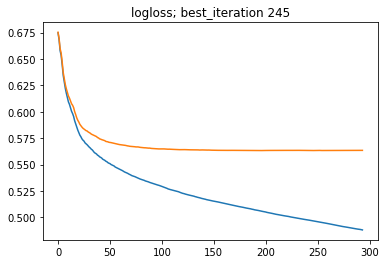

In [21]:
plt.plot(evalres['tr']['binary_logloss'])
plt.plot(evalres['vl']['binary_logloss'])
plt.title(f"logloss; best_iteration {bst.best_iteration}")
plt.show()

## model features

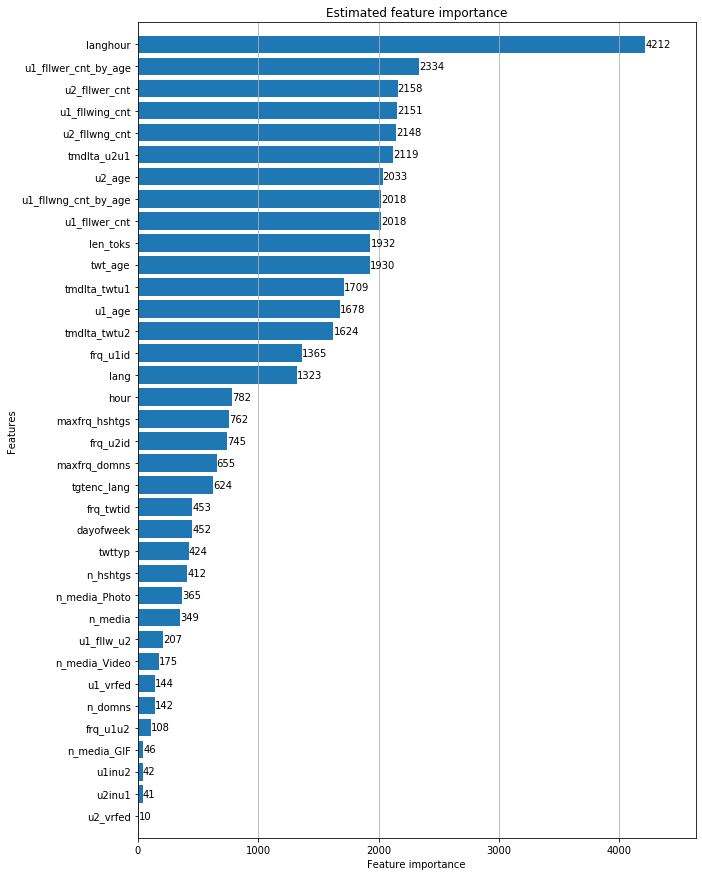

In [22]:
ax = lgb.plot_importance(bst, height=0.8, max_num_features=50, figsize=(10,15))
ax.grid(False, axis="y")
ax.set_title(f'Estimated feature importance')
plt.show()

In [23]:
pd.DataFrame([bst.feature_name(), bst.feature_importance()]).T.sort_values(1, ascending=False)

,0,1
28,langhour,4212
26,u1_fllwer_cnt_by_age,2334
5,u2_fllwer_cnt,2158
3,u1_fllwing_cnt,2151
6,u2_fllwng_cnt,2148
20,tmdlta_u2u1,2119
25,u2_age,2033
2,u1_fllwer_cnt,2018
27,u1_fllwng_cnt_by_age,2018
11,len_toks,1932


In [24]:
col2imp = dict(zip(bst.feature_name(), bst.feature_importance()))
sorted(col2imp.items(), key=lambda x: -x[1])

[('langhour', 4212),
 ('u1_fllwer_cnt_by_age', 2334),
 ('u2_fllwer_cnt', 2158),
 ('u1_fllwing_cnt', 2151),
 ('u2_fllwng_cnt', 2148),
 ('tmdlta_u2u1', 2119),
 ('u2_age', 2033),
 ('u1_fllwer_cnt', 2018),
 ('u1_fllwng_cnt_by_age', 2018),
 ('len_toks', 1932),
 ('twt_age', 1930),
 ('tmdlta_twtu1', 1709),
 ('u1_age', 1678),
 ('tmdlta_twtu2', 1624),
 ('frq_u1id', 1365),
 ('lang', 1323),
 ('hour', 782),
 ('maxfrq_hshtgs', 762),
 ('frq_u2id', 745),
 ('maxfrq_domns', 655),
 ('tgtenc_lang', 624),
 ('frq_twtid', 453),
 ('dayofweek', 452),
 ('twttyp', 424),
 ('n_hshtgs', 412),
 ('n_media_Photo', 365),
 ('n_media', 349),
 ('u1_fllw_u2', 207),
 ('n_media_Video', 175),
 ('u1_vrfed', 144),
 ('n_domns', 142),
 ('frq_u1u2', 108),
 ('n_media_GIF', 46),
 ('u1inu2', 42),
 ('u2inu1', 41),
 ('u2_vrfed', 10)]

In [25]:
[o[0] for o in sorted(col2imp.items(), key=lambda x: -x[1]) if o[1]>0]

['langhour',
 'u1_fllwer_cnt_by_age',
 'u2_fllwer_cnt',
 'u1_fllwing_cnt',
 'u2_fllwng_cnt',
 'tmdlta_u2u1',
 'u2_age',
 'u1_fllwer_cnt',
 'u1_fllwng_cnt_by_age',
 'len_toks',
 'twt_age',
 'tmdlta_twtu1',
 'u1_age',
 'tmdlta_twtu2',
 'frq_u1id',
 'lang',
 'hour',
 'maxfrq_hshtgs',
 'frq_u2id',
 'maxfrq_domns',
 'tgtenc_lang',
 'frq_twtid',
 'dayofweek',
 'twttyp',
 'n_hshtgs',
 'n_media_Photo',
 'n_media',
 'u1_fllw_u2',
 'n_media_Video',
 'u1_vrfed',
 'n_domns',
 'frq_u1u2',
 'n_media_GIF',
 'u1inu2',
 'u2inu1',
 'u2_vrfed']

# eval

In [26]:
%%time
prdtr = bst.predict(dftr[cols_feat],num_iteration=bst.best_iteration)
prdvl = bst.predict(dfvl[cols_feat],num_iteration=bst.best_iteration)
prdval0 = bst.predict(dfval[cols_feat],num_iteration=bst.best_iteration)
prdval = calibration(prdval0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 1min 11s, sys: 8.18 s, total: 1min 19s
Wall time: 8.02 s


In [27]:
%%time
ytr,yvl,yval=[df[TCOL].values for df in (dftr,dfvl,dfval)]

auc_tr=compute_prauc(prdtr, ytr)
rce_tr=compute_rce(prdtr, ytr)
auc_vl=compute_prauc(prdvl, yvl)
rce_vl=compute_rce(prdvl, yvl)
auc_val=compute_prauc(prdval, yval)
rce_val=compute_rce(prdval, yval)

results['scrs'] = {}
results['scrs']['auc_tr']=auc_tr
results['scrs']['rce_tr']=rce_tr
results['scrs']['auc_vl']=auc_vl
results['scrs']['rce_vl']=rce_vl
results['scrs']['auc_val']=auc_val
results['scrs']['rce_val']=rce_val

CPU times: user 3.17 s, sys: 238 ms, total: 3.4 s
Wall time: 3.08 s


In [28]:
print(f'auc_tr:  {auc_tr:.4f}')
print(f'auc_vl:  {auc_vl:.4f}')
print(f'auc_val: {auc_val:.4f}')
print()
print(f'rce_tr:  {rce_tr:.4f}')
print(f'rce_vl:  {rce_vl:.4f}')
print(f'rce_val: {rce_val:.4f}')

auc_tr:  0.8127
auc_vl:  0.7318
auc_val: 0.7250

rce_tr:  27.4943
rce_vl:  17.9988
rce_val: 17.4247


## score

In [29]:
print(f'-{auc_val:.4f}-{rce_val:.4f}')

-0.7250-17.4247


# save results

In [30]:
pickle.dump(results, open(f'{p_out}/results_{PRFX}.p', 'wb'))

# infer

In [31]:
results = pickle.load( open(f'{p_out}/results_{PRFX}.p', 'rb'))
bst = results['bst']
col2tgtenc = results['col2tgtenc']
cols_feat = results['cols_feat']
tgt_encoder = results['tgt_encoder']

## prep

In [32]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{tsttmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
    nrows=10
)

CPU times: user 36.5 ms, sys: 93.4 ms, total: 130 ms
Wall time: 8.66 ms


In [33]:
%%time
dftst=prp_df(dftst, tm_max=tm_tst_max)

2020-04-11 23:16:06 start
2020-04-11 23:16:06 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-11 23:16:06 freq of tags
2020-04-11 23:16:06 done
CPU times: user 215 ms, sys: 406 ms, total: 620 ms
Wall time: 142 ms


In [34]:
encoded_tst = tgt_encoder.transform(dftst[col2tgtenc].astype(object))
tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tst.columns]
encoded_tst.columns = tgtenc_columns
dftst = pd.concat([dftst, encoded_tst], 1)
dftst.drop(columns=['u1id','u1u2'], inplace=True)
cols_category=['twttyp', 'lang', 'langhour']
dftst[cols_category]=dftst[cols_category].astype('category')

## predict

In [35]:
%%time
prdtst0 = bst.predict(dftst[cols_feat],num_iteration=bst.best_iteration)
prdtst = calibration(prdtst0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 27.8 ms, sys: 1.38 ms, total: 29.2 ms
Wall time: 20.6 ms


In [36]:
dfsub_ids = dftst[['twtid','u2id',]]
dfsub = dfsub_ids.copy()
dfsub['scr'] = prdtst
dfsub.to_csv(f'{p_out}/{TGT}__{PRFX}.csv',index=False,header=False)